# 临时设置代理，方便能够访问huggingface 等外网

In [15]:
import os

# 设置 HTTP/HTTPS 代理（根据你的代理地址修改）
os.environ["http_proxy"] = "http://127.0.0.1:7890"
os.environ["https_proxy"] = "http://127.0.0.1:7890"

# 了解数据集

In [16]:
import torch
import torch.nn as nn
from datasets import load_dataset
from torch.utils.data import DataLoader
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
# 按照空格拆分词
from tokenizers.pre_tokenizers import Whitespace

## 数据集样式：
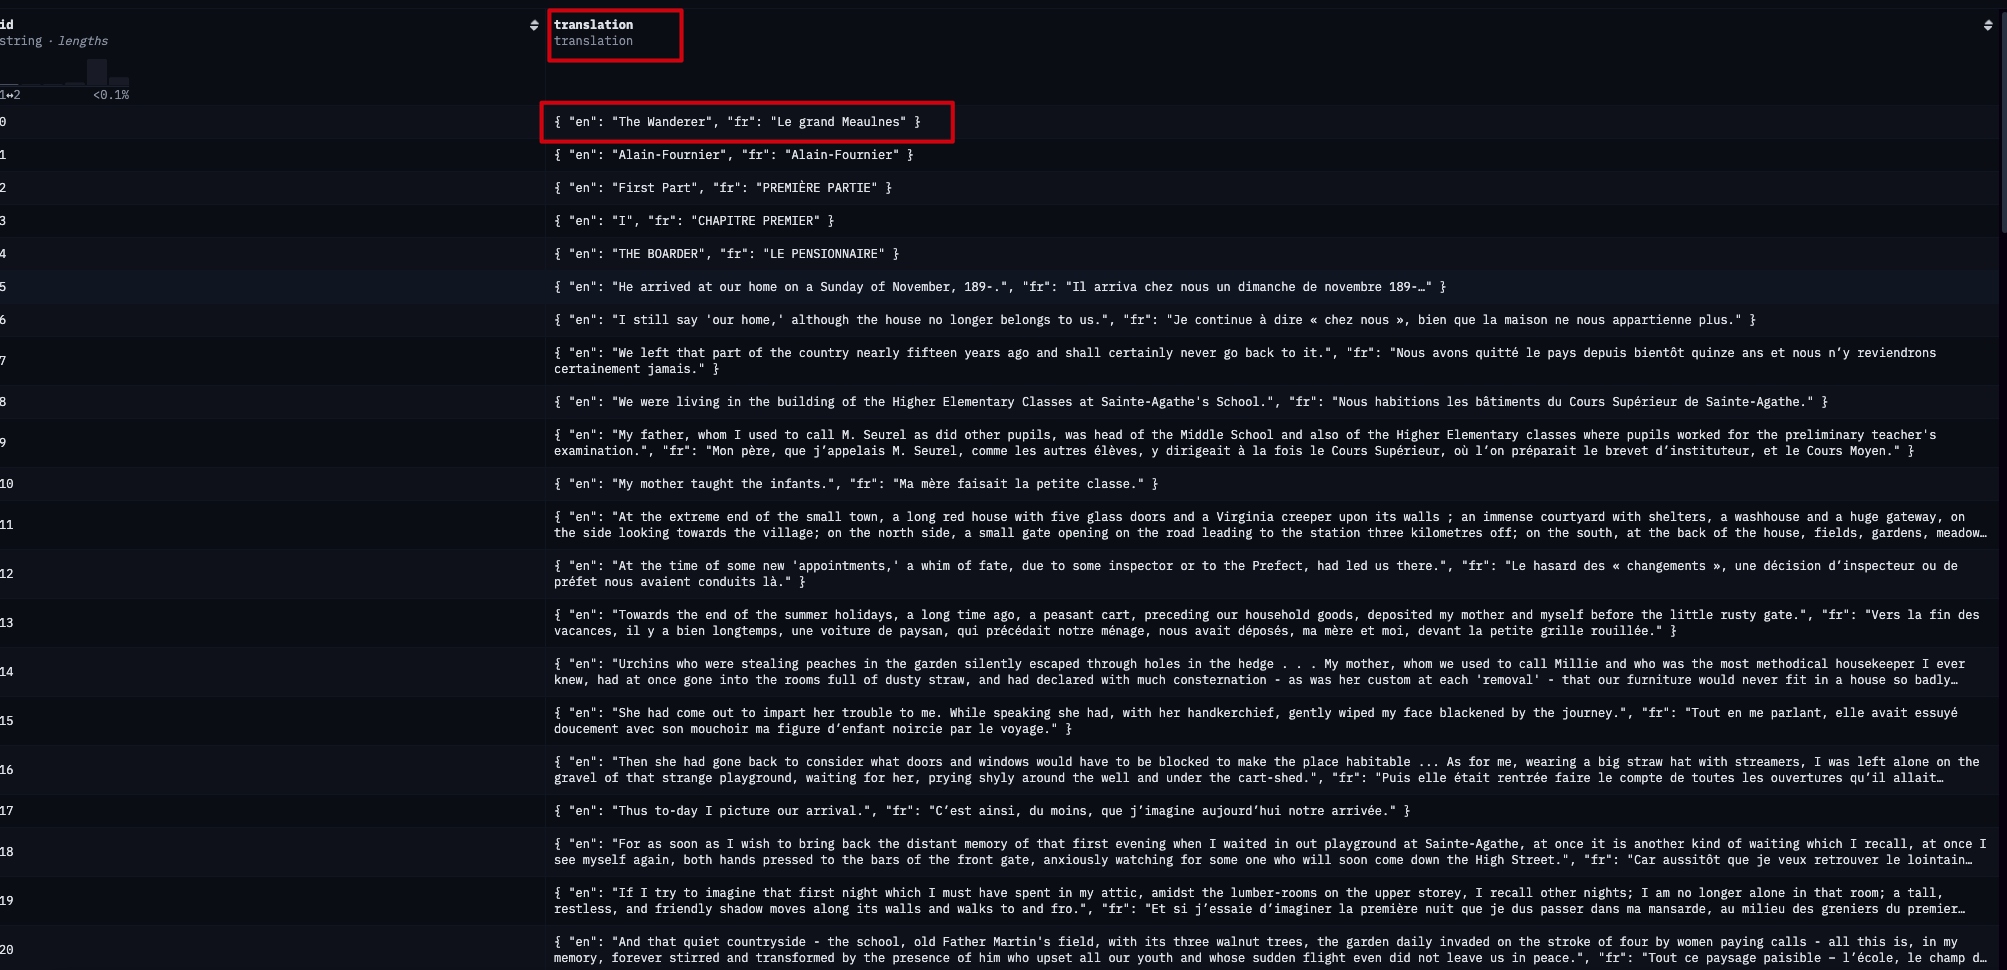

In [17]:
from pathlib import Path

def get_all_sentences(ds, lang):
    for item in ds:
        # 对应数据集的样式
        yield item['translation'][lang]

def get_or_build_tokenizer(config, ds, lang):
    tokenizer_path = Path(config['tokenizer_file'].format(lang))
    print(f'加载{lang}语言的tokenizer分词器文件...')
    if not Path.exists(tokenizer_path):
        tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
        tokenizer.pre_tokenizer = Whitespace()
        trainer = WordLevelTrainer(min_frequency=2, 
                                   special_tokens=["[UNK]", "[PAD]", "[SOS]", "[EOS]"])
        tokenizer.train_from_iterator(get_all_sentences(ds, lang), trainer=trainer)
        tokenizer.save(str(tokenizer_path))
    else:
        tokenizer = Tokenizer.from_file(str(tokenizer_path))
    
    return tokenizer
    
        

## 下载真实的数据
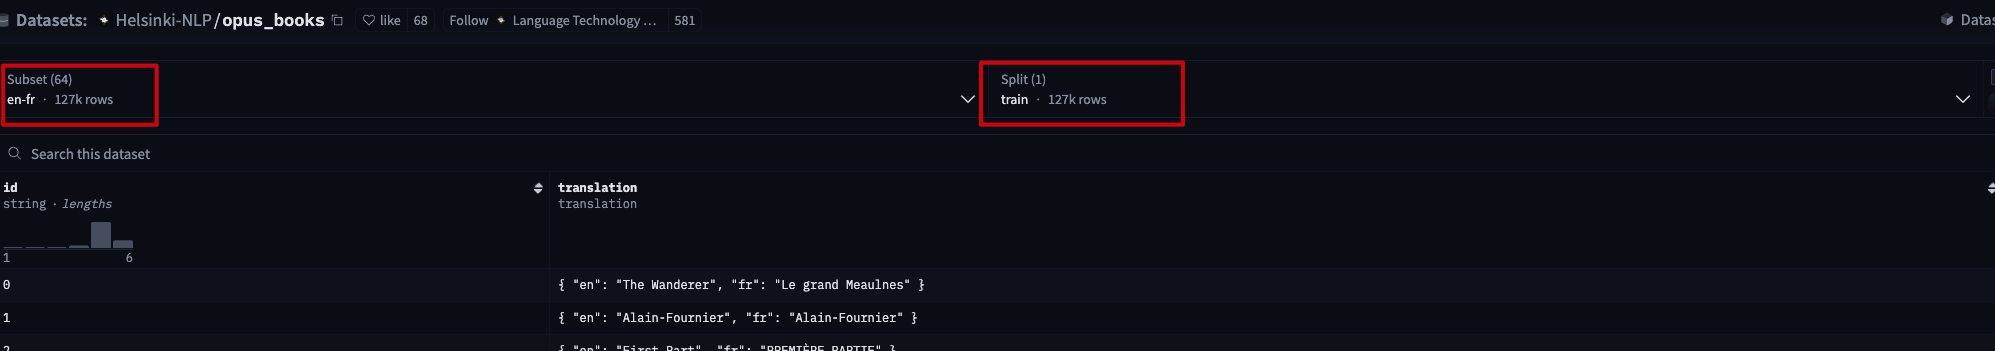

In [18]:
from torch.utils.data import random_split

def get_ds(config):
    # download data
    ds_raw = load_dataset('opus_books', 
                          f'{config['lang_src']}-{config['lang_tgt']}', 
                          split='train',
                          num_proc=4,  # 多线程下载 
                          download_mode="force_redownload",
                          )
    # build src and tgt tokenizers
    tokenizer_src = get_or_build_tokenizer(config, ds_raw, config['lang_src'])
    tokenizer_tgt = get_or_build_tokenizer(config, ds_raw, config['lang_tgt'])
    
    # 拆分训练集和测试集
    ds_size = len(ds_raw)
    train_ds_size = int(0.9 * ds_size)
    valid_ds_size = ds_size - train_ds_size#
    # todo 调试还行，真运行不能这么打印
    # print(train_ds_size, valid_ds_size)
    train_ds_raw, val_ds_raw = random_split(ds_raw, [train_ds_size, valid_ds_size])
    return train_ds_raw, val_ds_raw, tokenizer_src, tokenizer_tgt
    

In [19]:
from mydataset import TransformerDataset

In [20]:
from dataclasses import dataclass


@dataclass
class Config:
    lang_src: str
    lang_tgt: str
    tokenizer_file: str
    seq_len: int = 64

In [21]:
# config = {}
# config['lang_src'] = 'en' 
# config['lang_tgt'] = 'it'
# config['tokenizer_file'] = '../data/translation_file_{}.txt'


# train_ds_raw, val_ds_raw, tokenizer_src, tokenizer_tgt = get_ds(config)



In [22]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tokenizers import Tokenizer
class TransformerDataset(Dataset):
    
    def __init__(self, 
                 ds, 
                 src_tokenizer: Tokenizer, 
                 tgt_tokenizer: Tokenizer, 
                 src_lang: str, 
                 tgt_lang: str, 
                 seq_len: int):
        super().__init__()
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        self.ds = ds
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang
        self.seq_len = seq_len
        
        self.sos_token = torch.tensor([self.src_tokenizer.token_to_id('[SOS]')], dtype = torch.int64)
        self.eos_token = torch.tensor([self.src_tokenizer.token_to_id('[EOS]')], dtype = torch.int64)
        self.pad_token = torch.tensor([self.src_tokenizer.token_to_id('[PAD]')], dtype = torch.int64)
    
    def __len__(self):
        return len(self.ds)
    
    
    def __getitem__(self, index):
        
        src_tgt_value_pair = self.ds[index]
        input_text = src_tgt_value_pair['translation'][self.src_lang]
        tgt_text = src_tgt_value_pair['translation'][self.tgt_lang]
        #print(f'input text = {input_text}, \n翻译对应的文本 = {tgt_text}')
        src_tokens = self.src_tokenizer.encode(input_text).ids
        #print(f'输入的文本encode的编码数字是: {src_tokens}')
        
        #retry_decode = self.src_tokenizer.decode(src_tokens)
        #print(retry_decode)
        tgt_tokens = self.tgt_tokenizer.encode(tgt_text).ids
        
        #print(f'源头数据长度{len(src_tokens)}, 目标数据长度{len(tgt_tokens)}')
        
        src_pad_len = self.seq_len - len(src_tokens) - 2
        tgt_pad_len = self.seq_len - len(tgt_tokens) - 1
        if src_pad_len < 0 or tgt_pad_len < 0:
            raise ValueError('输入的文本长度大于模型输入长度')
        
        # 源 这行输入句子的input tensor
        encoder_src_tokens = torch.cat(
            [
                self.sos_token,
                torch.tensor(src_tokens, dtype=torch.int64),
                self.eos_token,
                torch.tensor([self.pad_token] * src_pad_len, dtype = torch.int64)
            ]
        )
        
        # tgt 训练 input tensor
        decoder_tgt_tokens = torch.cat(
            [
                self.sos_token,
                torch.tensor(tgt_tokens, dtype = torch.int64),
                torch.tensor([self.pad_token] * tgt_pad_len, dtype = torch.int64)
            ]
        )
        
        # label tensor
        label_tokens = torch.cat(
            [
                torch.tensor(tgt_tokens, dtype = torch.int64),
                self.eos_token,
                torch.tensor([self.pad_token] * tgt_pad_len, dtype = torch.int64)
            ]
        )
        
        # 源的mask： 遮挡PAD部分的数据
        src_mask = (encoder_src_tokens != self.pad_token).unsqueeze(0).unsqueeze(0).int() # (1,1, seq_len) 
        
        # tgt_mask 遮挡当前词后面的词以及填充词
        tgt_mask = (decoder_tgt_tokens != self.pad_token).unsqueeze(0).unsqueeze(0).int() & torch.tril(torch.ones((1, self.seq_len, self.seq_len), dtype=torch.int64))
        
        assert encoder_src_tokens.size(0) == self.seq_len
        assert decoder_tgt_tokens.size(0) == self.seq_len
        #print(f'len of label_tokens = {label_tokens.size(0)}, seq_len = {self.seq_len}')
        assert label_tokens.size(0) == self.seq_len
        return {
            'encoder_input': encoder_src_tokens, # (seq_len,)
            'decoder_input': decoder_tgt_tokens, # (seq_len,)
            
            'encoder_mask': src_mask, # (1,1, seq_len)
            'decoder_mask': tgt_mask, # (1,1, seq_len) & (1, seq_len, seq_len) --> (1,seq_len, seq_len)
            'label': label_tokens, # (seq_len,)
            'src_text': input_text,
            'tgt_text': tgt_text,
        }
            
        
        



In [23]:
# transformer_dataset = TransformerDataset(train_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], 128)
# print(len(transformer_dataset))
# next(iter(transformer_dataset))

In [24]:
def get_max_sequence_len(ds, lang: str, tokenizer: Tokenizer) -> int:
    max_seq_len = 0
    size = 0
    for item in ds:
        size += 1
        if size < 10 == 0:
            print(item)
        input = item['translation'][lang]
        if size < 10:
        
            print(f'inpuyt = {input}')
        token_ids= tokenizer.encode(input).ids
        if size < 10:
            print(f'token_ids： {token_ids}')
        max_len_single_senquence = max(token_ids)
        max_seq_len = max(max_seq_len, max_len_single_senquence)
    
    return max_seq_len

def get_src_tgt_max_sequence_len(ds, lang_src: str, lang_tgt: str, tokenizer_src: Tokenizer, tokenizer_tgt: Tokenizer) -> int:
    src_max_seq_len = 0
    tgt_max_seq_len = 0
    size = 0
    for item in ds:
        size += 1
        if size < 10 == 0:
            print(item)
        src_input = item['translation'][lang_src]
        tgt_input = item['translation'][lang_tgt]
        
        if size < 10:
        
            print(f'src_input={src_input}, tgt_input={tgt_input}')
        src_token_ids = tokenizer_src.encode(src_input).ids
        tgt_token_ids = tokenizer_tgt.encode(tgt_input).ids
        if size < 10:
            print(f'src_token_ids={src_token_ids}, tgt_token_ids={tgt_token_ids}')
        src_max_len_single_senquence = max(src_token_ids)
        tgt_max_len_single_senquence = max(tgt_token_ids)
        src_max_seq_len = max(src_max_seq_len, src_max_len_single_senquence)
        tgt_max_seq_len = max(tgt_max_seq_len, tgt_max_len_single_senquence)
    
    return src_max_seq_len, tgt_max_seq_len

def get_transformer_dataloader(config, train_ds_raw, val_ds_raw, tokenizer_src, tokenizer_tgt):
    # 训练集的transformer dataset
    train_ds = TransformerDataset(train_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])
    # 验证集的transformer dataset
    val_ds = TransformerDataset(val_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])
    
    # src_max_len = get_max_sequence_len(train_ds_raw, config['lang_src'], tokenizer_src)
    # tgt_max_len = get_max_sequence_len(train_ds_raw, config['lang_tgt'], tokenizer_tgt)
    src_max_len, tgt_max_len = get_src_tgt_max_sequence_len(train_ds_raw, config['lang_src'], config['lang_tgt'], tokenizer_src, tokenizer_tgt)
    print(f'源语言最大长度是: {src_max_len}, 目标语言最大长度是: {tgt_max_len}')
    
    train_ds_loader = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True)
    val_ds_loader = DataLoader(val_ds, batch_size=1, shuffle=False)
    return train_ds_loader, val_ds_loader, tokenizer_src, tokenizer_tgt

In [25]:
# config['seq_len'] = 350
# config['batch_size'] = 2
#get_tranformer_dataloader(config, train_ds_raw, val_ds_raw, tokenizer_src, tokenizer_tgt)

In [26]:
from transformer_model import build_transformer
def get_model(config, vocab_src_len, vocab_tgt_len):
    
    return build_transformer(
        vocab_src_len, 
        vocab_tgt_len, 
        config['seq_len'], 
        config['seq_len'],
        d_model=config['d_model'],
        )


In [27]:
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from config import get_weights_file_path, get_config
def train_model(config):
    # define device for training
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'use device {device}')
    
    Path(config["model_folder"]).mkdir(parents=True, exist_ok = True)
    train_ds_raw, val_ds_raw, tokenizer_src, tokenizer_tgt = get_ds(config)

    train_ds_loader, val_ds_loader, tokenizer_src, tokenizer_tgt = get_transformer_dataloader(config, train_ds_raw, val_ds_raw, tokenizer_src, tokenizer_tgt)
    
    model = get_model(config, tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size()).to(device)
    
    # Tensorboard
    writer = SummaryWriter(config['experiment_name'])
    
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], eps=1e-9)
    
    initial_epoch = 0
    global_step = 0
    if config['preload']:
        model_filename = get_weights_file_path(config, config['preload'])
        print(f'Preloading model from {model_filename}')
        state = torch.load(model_filename)
        initial_epoch = state['epoch']
        optimizer.load_state_dict(state['optimizer_state_dict'])
        global_step = state['global_step']
    
    loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer_src.token_to_id('[PAD]'), label_smoothing=0.1).to(device)
    
    for epoch in range(initial_epoch, config['num_epochs']):
        
        batch_iterator = tqdm(train_ds_loader, desc = f'Processing epoch {epoch:02d}')
        
        for batch in batch_iterator:
            model.train()
            encoder_input = batch['encoder_input'].to(device) # (bs, seq_Len)
            decoder_input = batch['decoder_input'].to(device) # (bs, seq_Len)
            encoder_mask = batch['encoder_mask'].to(device) #(bs, 1,1,seq_Len)
            decoder_mask = batch['decoder_mask'].to(device) #(bs, 1, seq_Len, seq_Len)
            
            # run the rensors through the transformer
            encoder_output = model.encode(encoder_input, encoder_mask) # (bs, seq_Len, d_model)
            decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask) # (bs, seq_Len, d_model)
            # 投影到词汇表上
            project_output = model.project(decoder_output) #(bs, seq_Len, tgt_vocab_size)
            
            label = batch['label'].to(device) # (bs, seq_Len)
            
            # (bs, seq_Len, tgt_vocab_size) --> (bs * seq_Len, tgt_vocab_size)
            loss = loss_fn(project_output.view(-1, tokenizer_tgt.get_vocab_size()), label.view(-1))
            batch_iterator.set_postfix({f"loss": f"{loss.item(): 6.3f}"})
            
            # Log the loss
            writer.add_scalar('train loss', loss.item(), global_step)
            writer.flush()
            
            # backpropagate the loss
            loss.backward()
            # update the weights
            optimizer.step()
            optimizer.zero_grad()
            
            global_step += 1
        
        # run_validation(model, validation_ds, tokenizer_src, tokenizer_tgt, max_len, device, print_msg, globl_state, writer, num_examples=2)

        run_validation(model, val_ds_loader, tokenizer_src, tokenizer_tgt, config['seq_len'], device, lambda msg: batch_iterator.writer(msg), global_step, writer, num_examples=2)

        
        # save the model at the end of every epoch
        model_filename = get_weights_file_path(config, f'{epoch:02d}')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'global_step': global_step,
        }, model_filename
        )



            
            
            
    

In [28]:
config = get_config()
train_model(config)

Using the latest cached version of the dataset since opus_books couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'en-it' at /home/kason/.cache/huggingface/datasets/opus_books/en-it/0.0.0/1f9f6191d0e91a3c539c2595e2fe48fc1420de9b (last modified on Sun May 25 21:25:46 2025).


use device cuda
加载en语言的tokenizer分词器文件...
加载it语言的tokenizer分词器文件...
src_input=Afternoon arrived: Mrs. Fairfax assumed her best black satin gown, her gloves, and her gold watch; for it was her part to receive the company,--to conduct the ladies to their rooms, &c., tgt_input=Nel dopo pranzo la signora Fairfax si mise un bel vestito di raso nero, i guanti e l'orologio d'oro, perché doveva ricever gli ospiti e condurre le signore nelle loro camere.
src_token_ids=[0, 948, 38, 352, 7, 657, 2426, 23, 402, 569, 3296, 2705, 4, 23, 2533, 4, 6, 23, 1334, 782, 18, 26, 17, 14, 23, 300, 8, 1195, 5, 1015, 732, 8, 1645, 5, 667, 8, 79, 1473, 4, 1854, 1484, 7], tgt_token_ids=[544, 96, 445, 11, 209, 769, 18, 424, 15, 606, 718, 7, 3524, 1073, 4, 32, 2451, 6, 24, 29, 1075, 46, 29, 1147, 4, 70, 344, 12292, 38, 1089, 6, 1682, 23, 202, 245, 69, 3285, 5]
src_input=When I showed myself to the two hostages, it was with the captain, who told them I was the person the governor had ordered to look after them; and th

Processing epoch {epoch:02d}: 100%|██████████| 3638/3638 [16:52<00:00,  3.59it/s, loss=9.915]


In [29]:

# from datasets import DownloadConfig
# #download_config = DownloadConfig(timeout=60)
# dataset = load_dataset(
#    "opus_books", 
#    "en-fr",  
#    split='train',
#    num_proc=4,  # 多线程下载 
#    download_mode="force_redownload"
#    )  # 替换为需要的语言对
# print(len(dataset))  # 输出训练集的大小

In [ ]:
def causal_mask(size):
    mask = torch.triu(torch.ones((1, size, size)), diagonal=1).type(torch.int)
    return mask == 0
def greedy_decode(model, source, source_mask, tokenizer_src, tokenizer_tgt, max_len, device):
    sos_idx = tokenizer_tgt.token_to_id('[SOS]')
    eos_idx = tokenizer_tgt.token_to_id('[EOS]')
    
    # Precompute the encoder output and reuse it for every token we get from the decoder
    encoder_output = model.encode(source, source_mask)
    # initialize the decoder input with the sos token
    decoder_input = torch.empty(1, 1).fill_(sos_idx).type_as(source).to(device)
    
    while True:
        # 如果decoder_input的行数等于max_len，则说明已经生成了max_len个token，跳出循环
        if decoder_input.size(1) == max_len:
            break
        
        # build tmask for the target(decoder input)。 这个是动态的，因为decoder_input的行数是动态的，他不会因为一个词一个词的不断回答而变化
        decoder_mask = causal_mask(decoder_input.size(1)).type_as(source_mask).to(device)
        
        # calculate the decoder output
        out = model.decode(encoder_output, source_mask, decoder_input, decoder_mask)
        
        # get the next token
        prob = model.project(out[:, -1])
        
        next_word = torch.argmax(prob, dim=-1)
        
        decoder_input = torch.cat([decoder_input, torch.empty(1,1).fill_(next_word.item()).type_as(source).to(device)], dim=1)
        
        if next_word == eos_idx:
            break
    
    return decoder_input.squeeze(0)
        
    
    

def run_validation(model, validation_ds, tokenizer_src, tokenizer_tgt, max_len, device, print_msg, globl_state, writer, num_examples=2):
    model.eval()
    count = 0
    
    source_texts = []
    expected = []
    predicted = []
    
    # Size of the control window (just use a default value)
    console_width = 80
    
    with torch.no_grad():
        for batch in validation_ds:
            count += 1
            encoder_input = batch['encoder_input'].to(device) # (bs, seq_Len)
            encoder_mask = batch['encoder_mask'].to(device) #(bs, 1,1,seq_Len)
            
            assert encoder_input.size(0) == 1, "Batch size must be 1 for validation"
            
            # 获取预测的句子的idx
            model_out = greedy_decode(model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len=max_len, device=device)

            source_text = batch['src_text'][0]     
            target_text = batch['tgt_text'][0]      
            model_out_text = tokenizer_tgt.decode(model_out.detach().cpu().numpy()) 
            
            source_texts.append(source_text)
            expected.append(target_text)
            predicted.append(model_out_text)
            
            # Print to the console
            print_msg('-' * console_width)
            print_msg(f'SOURCE: {source_text}')
            print_msg(f'TARGET: {target_text}')
            print_msg(f'PREDICTED: {model_out_text}')
            
            if count == num_examples:
                break
            

In [30]:
config = {}
config['lang_src'] = 'en' 
config['lang_tgt'] = 'it'
config['tokenizer_file'] = '../data/translation_file_{}.txt'
tokenizer_path = Path(config['tokenizer_file'].format(config['lang_src']))
print(Path.exists(tokenizer_path))

True
